In [2]:
import os
import glob
import pandas as pd

# === Configuration ===
DATA_DIR = "data"                  # Folder containing all device data files
PATTERNS = ["*.txt", "*.csv"]      # File name patterns to match
HOUR_AGG = "mean"                  # Hourly aggregation method: 'mean' or 'sum'
OUTPUT_CSV = "total_power_hourly.csv"

def read_device_file(path: str) -> pd.Series:
    """
    Read a single device file and return a pandas Series of power values (in watts),
    indexed by timestamp.

    Prefers 'ActiveThreePhasePower_W' if available, otherwise sums
    'L1ActivePower_W' + 'L2ActivePower_W' + 'L3ActivePower_W'.
    """
    # Read CSV safely (skip bad lines)
    df = pd.read_csv(
        path,
        encoding="utf-8",
        on_bad_lines="skip",
    )
    df.columns = [c.strip() for c in df.columns]

    # Identify the timestamp column
    time_candidates = ["timeval", "time", "timestamp", "Time", "TIME"]
    time_col = next((c for c in time_candidates if c in df.columns), None)
    if time_col is None:
        raise ValueError(f"{os.path.basename(path)}: no time column found (e.g. 'timeval').")

    # Parse timestamps
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    df = df.dropna(subset=[time_col])
    df = df.sort_values(time_col).set_index(time_col)

    # Select power column
    if "ActiveThreePhasePower_W" in df.columns:
        power = pd.to_numeric(df["ActiveThreePhasePower_W"], errors="coerce")
    else:
        parts = []
        for c in ["L1ActivePower_W", "L2ActivePower_W", "L3ActivePower_W"]:
            if c in df.columns:
                parts.append(pd.to_numeric(df[c], errors="coerce"))
        if parts:
            power = sum(parts)
        else:
            raise ValueError(
                f"{os.path.basename(path)}: no power column found (ActiveThreePhasePower_W or L1/L2/L3ActivePower_W)."
            )

    power = power.fillna(0.0)
    power.name = os.path.basename(path)
    return power

def main():
    # Collect all matching files
    files = []
    for pat in PATTERNS:
        files.extend(glob.glob(os.path.join(DATA_DIR, pat)))
    if not files:
        raise FileNotFoundError(f"No data files found in '{DATA_DIR}' matching {PATTERNS}.")

    # Read all device data
    series_list = []
    for f in sorted(files):
        try:
            s = read_device_file(f)
            series_list.append(s)
        except Exception as e:
            print(f"[WARN] Skipping {f}: {e}")

    if not series_list:
        raise RuntimeError("No valid device files were successfully read.")

    # Combine all devices by time and sum (15-min resolution total power)
    total_15min = pd.concat(series_list, axis=1).fillna(0.0).sum(axis=1)
    total_15min = total_15min.sort_index()
    total_15min.name = "power"

    # Aggregate from 15-min to 60-min
    if HOUR_AGG == "mean":
        total_hourly = total_15min.resample("H").mean()
    elif HOUR_AGG == "sum":
        total_hourly = total_15min.resample("H").sum()
    else:
        total_hourly = total_15min.resample("H").agg(HOUR_AGG)

    # Prepare final output (time, power)
    out = total_hourly.reset_index()
    out.columns = ["time", "power"]

    # Save to CSV
    out.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
    print(f"Saved file: {OUTPUT_CSV}")
    print(out.head())

if __name__ == "__main__":
    main()


[WARN] Skipping data/temp.txt: temp.txt: no time column found (e.g. 'timeval').
Saved file: total_power_hourly.csv
                 time         power
0 2018-05-10 04:00:00  39988.800000
1 2018-05-10 05:00:00  35310.000000
2 2018-05-10 06:00:00  35471.333333
3 2018-05-10 07:00:00  35681.333333
4 2018-05-10 08:00:00  35562.666667


Sampling interval: 1.000 hours/sample
Top 5 dominant periods (with phase info):
-----------------------------------------------------------
1. Frequency = 0.0007 cycles/day, Amplitude = 22,579.43, Period = 1447.250 days (34734.0 h), Phase = 2.820 rad, Peak at 55.1% of cycle (~19142.6 h after start)
2. Frequency = 0.9998 cycles/day, Amplitude = 7,121.50, Period = 1.000 days (24.0 h), Phase = -2.007 rad, Peak at 31.9% of cycle (~7.7 h after start)
3. Frequency = 0.0035 cycles/day, Amplitude = 6,944.74, Period = 289.450 days (6946.8 h), Phase = -2.745 rad, Peak at 43.7% of cycle (~3034.8 h after start)
4. Frequency = 0.0028 cycles/day, Amplitude = 6,384.31, Period = 361.812 days (8683.5 h), Phase = 0.076 rad, Peak at 98.8% of cycle (~8578.4 h after start)
5. Frequency = 0.0111 cycles/day, Amplitude = 5,766.40, Period = 90.453 days (2170.9 h), Phase = -0.947 rad, Peak at 15.1% of cycle (~327.2 h after start)

=== JSON summary ===
{
  "resample_rule": "1H",
  "top_k": 5,
  "n_samples": 3473

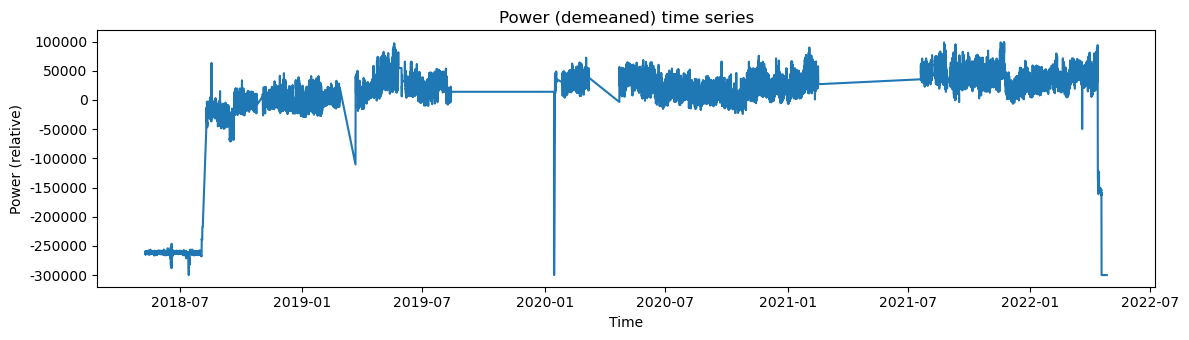

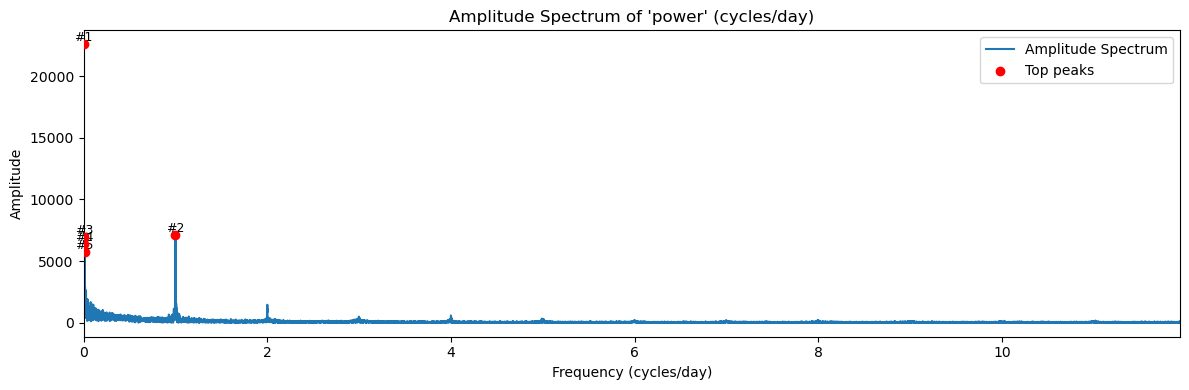

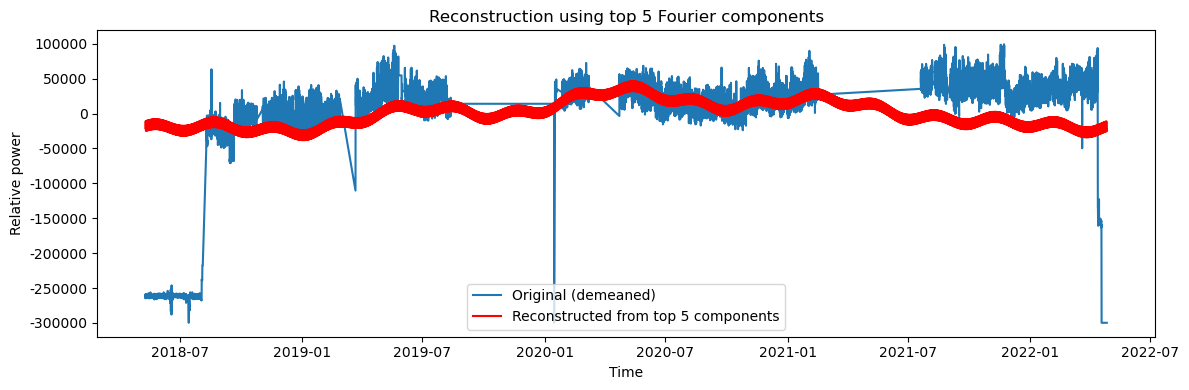

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# ==================== SETTINGS ====================
csv_path = Path("total_power_hourly.csv")  # Input CSV with columns: time,power
top_k = 5                                  # Top N frequencies to analyze
resample_rule = "1H"                       # Sampling frequency (hourly)
# ==================================================

# 1) Read data
df = pd.read_csv(csv_path, usecols=["time", "power"], parse_dates=["time"])
df = df.set_index("time").sort_index()

# Build the series (hourly mean in case there are duplicate stamps)
s = pd.to_numeric(df["power"], errors="coerce").resample(resample_rule).mean().interpolate("time")

if len(s) < 2:
    raise ValueError("Not enough samples for FFT. Need at least 2 time points.")

dt_hours = (s.index[1] - s.index[0]).total_seconds() / 3600.0

# 2) Demean & apply Hann window
x = s.values.astype(float)
x = x - np.nanmean(x)
window = np.hanning(len(x))
xw = x * window

# 3) FFT
X = np.fft.rfft(xw)
# Correct for window mean scaling (amplitude-preserving)
window_correction = np.sum(window) / len(window)
X = X / (len(x) * window_correction)

freq_cph = np.fft.rfftfreq(len(x), d=dt_hours)  # cycles per hour
freq_cpd = freq_cph * 24.0                      # cycles per day
amplitude = np.abs(X)
phase = np.angle(X)
# Double non-DC, non-Nyquist bins for one-sided amplitude spectrum
if len(amplitude) > 1:
    amplitude[1:-1] *= 2.0

# 4) Select top_k frequencies (excluding DC)
mask = freq_cpd > 0
freq_pos = freq_cpd[mask]
amp_pos = amplitude[mask]
phase_pos = phase[mask]

if len(freq_pos) == 0:
    raise ValueError("No positive frequencies found (check your time series length).")

idx = np.argsort(amp_pos)[::-1][:top_k]
dominant_freqs = freq_pos[idx]
dominant_amps = amp_pos[idx]
dominant_phases = phase_pos[idx]
dominant_period_days = 1.0 / dominant_freqs
dominant_period_hours = dominant_period_days * 24.0

# 5) Display main results
print(f"Sampling interval: {dt_hours:.3f} hours/sample")
print(f"Top {top_k} dominant periods (with phase info):")
print("-----------------------------------------------------------")
for i, (f, a, phi, pdays, phours) in enumerate(
    zip(dominant_freqs, dominant_amps, dominant_phases, dominant_period_days, dominant_period_hours), 1
):
    peak_fraction = (-phi / (2 * np.pi)) % 1.0
    peak_hours = peak_fraction * phours
    print(
        f"{i}. Frequency = {f:.4f} cycles/day, "
        f"Amplitude = {a:,.2f}, "
        f"Period = {pdays:.3f} days ({phours:.1f} h), "
        f"Phase = {phi:.3f} rad, "
        f"Peak at {peak_fraction*100:.1f}% of cycle (~{peak_hours:.1f} h after start)"
    )

# 6) Machine-readable JSON summary
results = {
    "resample_rule": str(resample_rule),
    "top_k": int(top_k),
    "n_samples": int(len(x)),
    "sampling_interval_hours": float(dt_hours),
    "time_start": s.index[0].isoformat(),
    "time_end": s.index[-1].isoformat(),
    "dominant_components": []
}

for f, a, phi, pdays, phours in zip(
    dominant_freqs, dominant_amps, dominant_phases, dominant_period_days, dominant_period_hours
):
    peak_fraction = float((-phi / (2 * np.pi)) % 1.0)   # position in cycle [0,1)
    peak_hours = float(peak_fraction * phours)           # hours after start when peak occurs

    results["dominant_components"].append({
        "frequency_cycles_per_day": float(f),
        "amplitude": float(a),
        "phase_rad": float(phi),
        "period_days": float(pdays),
        "period_hours": float(phours),
        "peak_fraction_of_cycle": peak_fraction,
        "peak_hours_after_start": peak_hours,
    })

print("\n=== JSON summary ===")
print(json.dumps(results, ensure_ascii=False, indent=2))

# 7) Plot configuration
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

# ---- (A) Time series (demeaned)
plt.figure(figsize=(12, 3.5))
plt.plot(s.index, x, label="Demeaned power")
plt.title("Power (demeaned) time series")
plt.xlabel("Time")
plt.ylabel("Power (relative)")
plt.tight_layout()
plt.show()

# ---- (B) Amplitude spectrum
plt.figure(figsize=(12, 4))
plt.plot(freq_cpd, amplitude, label="Amplitude Spectrum")
plt.scatter(dominant_freqs, dominant_amps, color="red", zorder=5, label="Top peaks")
for i, f in enumerate(dominant_freqs):
    plt.text(f, dominant_amps[i], f"#{i+1}", fontsize=9, ha='center', va='bottom')
plt.xlim(0, np.percentile(freq_cpd, 99.5))
plt.title("Amplitude Spectrum of 'power' (cycles/day)")
plt.xlabel("Frequency (cycles/day)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

# ---- (C) Optional: reconstruct dominant components
t = np.arange(len(x)) * dt_hours / 24.0  # time axis in days
reconstructed = np.zeros_like(x)
for f, A, phi in zip(dominant_freqs, dominant_amps, dominant_phases):
    reconstructed += A * np.cos(2 * np.pi * f * t + phi)

plt.figure(figsize=(12, 4))
plt.plot(s.index, x, label="Original (demeaned)")
plt.plot(s.index, reconstructed, label=f"Reconstructed from top {top_k} components", color="red")
plt.title(f"Reconstruction using top {top_k} Fourier components")
plt.xlabel("Time")
plt.ylabel("Relative power")
plt.legend()
plt.tight_layout()
plt.show()
